In [54]:
# data handling and analysis libraries
import geopandas as gpd
import pandas as pd
import numpy as np

# machine learning
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import xgboost as xgb

# visualization
import seaborn as sns
import matplotlib.pyplot as plt


load our main GeoDataFrame

In [55]:
gdf = gpd.read_file('cells_finish.shp')

arrange data for learning

In [56]:
gdf.columns

Index(['fid', 'location', 'min_height', 'max_height', 'avg_height',
       'std_height', 'nearest ci', 'week', 'year', 'fire', 'temperatur',
       'humidity', 'pressure', 'wind_speed', 'ULcorner_L', 'ULcorner_1',
       'geometry'],
      dtype='object')

In [57]:
gdf = gdf.rename(columns={"ULcorner_L": "ULcorner_Lat", "ULcorner_1": "ULcorner_Long"})

In [58]:
gdf = gdf.drop(columns=['fid', 'location', 'year','geometry', 'nearest ci'])

In [59]:
gdf.head()


,min_height,max_height,avg_height,std_height,week,fire,temperatur,humidity,pressure,wind_speed,ULcorner_Lat,ULcorner_Long
0,91.0,214.0,148.968819,25.747558,39.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-115.000417
1,141.0,463.0,205.685903,34.354413,39.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.900417
2,165.0,592.0,246.467083,33.330296,39.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.800417
3,61.0,521.0,230.628333,47.022054,39.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.700417
4,48.0,400.0,164.990556,49.978685,39.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.600417


In [60]:
gdf['fire'] = gdf['fire'].fillna(0)

In [61]:
gdf.head()

,min_height,max_height,avg_height,std_height,week,fire,temperatur,humidity,pressure,wind_speed,ULcorner_Lat,ULcorner_Long
0,91.0,214.0,148.968819,25.747558,39.0,0.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-115.000417
1,141.0,463.0,205.685903,34.354413,39.0,0.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.900417
2,165.0,592.0,246.467083,33.330296,39.0,0.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.800417
3,61.0,521.0,230.628333,47.022054,39.0,0.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.700417
4,48.0,400.0,164.990556,49.978685,39.0,0.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.600417


Preprocess: split data to features and labels

In [62]:
X = pd.DataFrame(gdf.loc[:, gdf.columns != 'fire'])
y = pd.DataFrame(gdf['fire'])
y.head()

,fire
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [112]:
# the test set will be the the last year we have data for
X_train = X.loc[:121680]
X_test = X.loc[121680:]
y_train = y.loc[:121680]
y_test = y.loc[121680:]


Feature Scaling

In [113]:
scalar = StandardScaler()
scalar.fit(X_train)

X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

### Training ANN using Scikit learn

Training and Predictions



In [66]:
mlps = []
mlps.append(MLPClassifier(hidden_layer_sizes=3, max_iter=1000))
mlps.append(MLPClassifier(hidden_layer_sizes=10, max_iter=1000))
mlps.append(MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000))

predictions = []
for i,mlp in enumerate(mlps):
    mlp.fit(X_train, y_train.values.ravel())
    predictions.append(mlp.predict(X_test))

Evaluate the Algorithm

In [67]:
for prediction in predictions:
    print(confusion_matrix(y_test,prediction))
    print(classification_report(y_test,prediction))
    print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ')


[[52924     0]
 [ 1156     0]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     52924
         1.0       0.00      0.00      0.00      1156

    accuracy                           0.98     54080
   macro avg       0.49      0.50      0.49     54080
weighted avg       0.96      0.98      0.97     54080

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
[[52922     2]
 [ 1156     0]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     52924
         1.0       0.00      0.00      0.00      1156

    accuracy                           0.98     54080
   macro avg       0.49      0.50      0.49     54080
weighted avg       0.96      0.98      0.97     54080

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
[[52910    14]
 [ 1150     6]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     52924
         1.0      

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Training Random forest using Scikit learn

In [116]:
forest_clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[[52905    19]
 [ 1141    15]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     52924
         1.0       0.44      0.01      0.03      1156

    accuracy                           0.98     54080
   macro avg       0.71      0.51      0.51     54080
weighted avg       0.97      0.98      0.97     54080



Text(0.5, 1.0, 'Visualizing Features Importance')

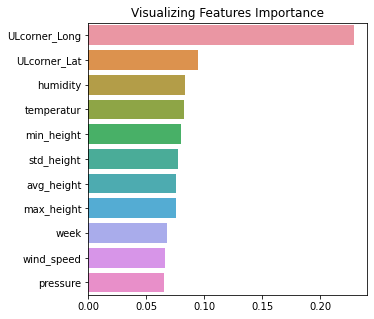

In [69]:
feature_importance = pd.Series(forest_clf.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Visualizing Features Importance')

### Training model using XGBoost


In [115]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 1, n_estimators = 100)
xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)
print(classification_report(y_test,y_pred))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     52924
         1.0       0.00      0.00      0.00      1156

    accuracy                           0.98     54080
   macro avg       0.49      0.50      0.49     54080
weighted avg       0.96      0.98      0.97     54080



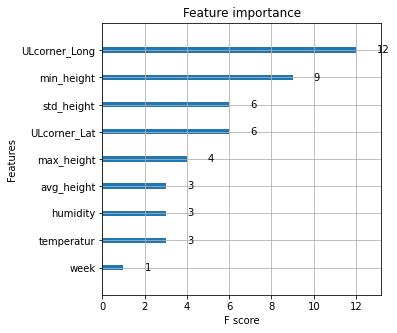

In [72]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [73]:
# xgb.plot_tree(xg_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

### Data Analysis

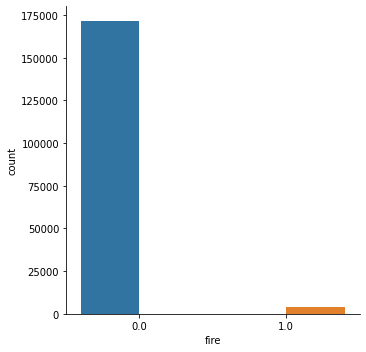

In [74]:
sns.catplot(x = "fire", hue="fire", kind="count", data=gdf)

we can see we have highly imbalanced classes

We will try upsampling

In [123]:
df_train = gdf.loc[:121680]
# Separate majority and minority classes
df_majority = df_train[df_train['fire']==0]
df_minority = df_train[df_train['fire']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=118615,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.fire.value_counts()

1.0    118615
0.0    118615
Name: fire, dtype: int64

In [124]:
y_train_upsampled = df_upsampled.fire
X_train_upsampled = df_upsampled.drop('fire', axis=1)

In [125]:
X_test = X.loc[121680:]

scalar = StandardScaler()
scalar.fit(X_train_upsampled)

X_train_upsampled = scalar.transform(X_train_upsampled)
X_test_upsampled = scalar.transform(X_test)

In [126]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train_upsampled,y_train_upsampled)

y_pred = xg_reg.predict(X_test_upsampled)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[37947 14977]
 [  206   950]]
              precision    recall  f1-score   support

         0.0       0.99      0.72      0.83     52924
         1.0       0.06      0.82      0.11      1156

    accuracy                           0.72     54080
   macro avg       0.53      0.77      0.47     54080
weighted avg       0.97      0.72      0.82     54080



In [127]:
forest_clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')
forest_clf.fit(X_train_upsampled, y_train_upsampled)
y_pred = forest_clf.predict(X_test_upsampled)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))



[[52732   192]
 [ 1094    62]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     52924
         1.0       0.24      0.05      0.09      1156

    accuracy                           0.98     54080
   macro avg       0.61      0.53      0.54     54080
weighted avg       0.96      0.98      0.97     54080



We will try Down sample

In [117]:
df_train = gdf.loc[:121680]
# Separate majority and minority classes
df_majority = df_train[df_train['fire']==0]
df_minority = df_train[df_train['fire']==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=3066,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled.fire.value_counts()


1.0    3066
0.0    3066
Name: fire, dtype: int64

In [118]:
y_train_downsampled = df_downsampled.fire
X_train_downsampled = df_downsampled.drop('fire', axis=1)

In [119]:
X_test = X.loc[121680:]

scalar = StandardScaler()
scalar.fit(X_train_downsampled)

X_train_downsampled = scalar.transform(X_train_downsampled)
X_test_downsampled = scalar.transform(X_test)

In [128]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train_upsampled,y_train_upsampled)

y_pred = xg_reg.predict(X_test_downsampled)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[42743 10181]
 [  304   852]]
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     52924
         1.0       0.08      0.74      0.14      1156

    accuracy                           0.81     54080
   macro avg       0.54      0.77      0.52     54080
weighted avg       0.97      0.81      0.87     54080



In [120]:
forest_clf = RandomForestClassifier(n_estimators=100)
forest_clf.fit(X_train_downsampled, y_train_downsampled)
y_pred = forest_clf.predict(X_test_downsampled)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[40912 12012]
 [  226   930]]
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87     52924
         1.0       0.07      0.80      0.13      1156

    accuracy                           0.77     54080
   macro avg       0.53      0.79      0.50     54080
weighted avg       0.97      0.77      0.85     54080



Text(0.5, 1.0, 'Visualizing Features Importance')

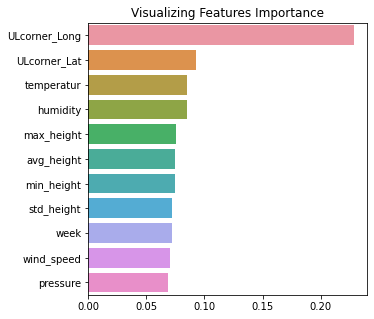

In [129]:
feature_importance = pd.Series(forest_clf.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Visualizing Features Importance')